# 4. Searching for similar weather patterns

## 4.1 Introduction
We are now going to use the compressed dataset to search for similar weather patterns. This is done by calculating the  euclidian distance between the datapoints for the reference date and all the other dates. Dates with the smallest distance will be those with the most similar weather. As this operation is computational intensive when the dimensions are big, this operation will be done on the compressed dataset. At the end of this notebook, we will check the correclation between the distance in commpressed and uncompressed (MSL/Z500) space.

We will start with the initializations for this notebook.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from isoplot import isoplot

# load data
era20c = np.load("data/era20c.npy")
compressed = np.load("data/era20c_compressed.npy")
dates = np.load("data/dates.npy")
scale = np.load("data/scale.npy")
zone = np.load("data/zone.npy")

# reshaping 2 spatial dimensions to 1, to be able to use the numpy norm
shape1 = era20c.shape[1]
shape2 = era20c.shape[2]
era20c = era20c.reshape(era20c.shape[0],shape1*shape2,era20c.shape[3])
compressed = compressed.reshape(compressed.shape[0],compressed.shape[1]*compressed.shape[2]*compressed.shape[3])

## 4.2 Search similar weather patterns
In the cell below a date can be set for searching similar pattern. The dates with the smallest difference in compressed space are listed in the table. The output also show the distance in uncompressed (scaled) MSL/Z500 space as well as the average difference per grid point in MSL (in Pa) and Z500 (in m<sup>2</sup>/s<sup>2</sup>).

In [2]:
# set the reference date here
date = "1990 1 25"
#date = "1953 1 31"
#date = "1976 1 2"
#date = "1976 8 1"
#date = "2003 8 10"

# corresponding reference data
date_index = np.where(dates == date)
compressed_ref = compressed[date_index]
era20c_ref = era20c[date_index]

# initialize arrays
compressed_dist = np.zeros(dates.shape[0])
msl_dist = np.zeros(dates.shape[0])
z500_dist = np.zeros(dates.shape[0])
era20c_dist = np.zeros(dates.shape[0])

# calculate distances
for i in range(dates.shape[0]):
    compressed_dist[i] = np.linalg.norm(compressed[i]-compressed_ref)
    era20c_dist[i] = np.linalg.norm(era20c[i]-era20c_ref)
    msl_dist[i] = np.linalg.norm((era20c[i,:,0]-era20c_ref[0,:,0]))
    z500_dist[i] = np.linalg.norm((era20c[i,:,1]-era20c_ref[0,:,1]))
    
# unscale and divide by number of gridpoints
msl_dist = ( msl_dist * (scale[0,1]-scale[0,0]) + scale[0,0] ) / era20c.shape[1]
z500_dist = ( z500_dist * (scale[1,1]-scale[1,0]) + scale[1,0] ) / era20c.shape[1]

# smallest distances
smallest_compressed = np.argsort(compressed_dist)[:25]
print("Index\tDate\t\tCompr.Dist.\tUncompr.Dist.\tMSL Dist.[Pa]\tZ500 Dist.[m**2/s**2]")
for i in smallest_compressed:
    print("%d\t%s\t%f\t%f\t%f\t%f" % (i,dates[i],compressed_dist[i],era20c_dist[i],msl_dist[i],z500_dist[i]))

Index	Date		Compr.Dist.	Uncompr.Dist.	MSL Dist.[Pa]	Z500 Dist.[m**2/s**2]
32896	1990 1 25	0.000000	0.000000	45.898438	20.996094
23757	1965 1 17	0.276384	3.085935	61.708177	34.340851
32142	1988 1 2	0.283846	3.450191	63.621552	35.841238
31432	1986 1 22	0.310287	3.825839	63.100698	40.775347
30693	1984 1 14	0.310761	3.731211	62.932458	39.983613
32180	1988 2 9	0.313180	3.663549	64.727258	36.743799
36154	1998 12 27	0.321177	3.307238	62.071687	36.439580
32897	1990 1 26	0.330812	3.570511	64.703277	35.593587
8086	1922 2 21	0.331699	3.984575	68.330350	34.478355
32913	1990 2 11	0.335628	3.791068	63.498691	39.932055
31493	1986 3 24	0.335878	3.339975	61.166238	37.968904
24912	1968 3 17	0.346438	4.196007	66.761526	40.100688
31431	1986 1 21	0.347848	4.592112	69.578595	40.608871
10967	1930 1 11	0.350298	4.126274	64.697396	42.040072
33241	1991 1 5	0.350751	4.024207	64.736685	40.902220
36174	1999 1 16	0.352210	3.807205	63.543250	40.050147
33239	1991 1 3	0.359464	3.444886	62.211162	37.798673
20801	1956 1

## 4.3 Plotting similar weather patterns
Plot the MSL/Z500 from the reference date together with the date with a similar weather pattern.

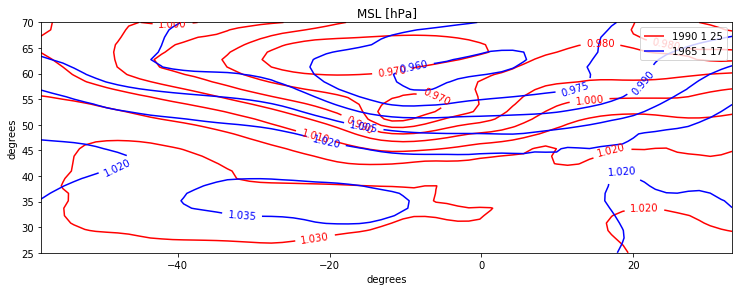

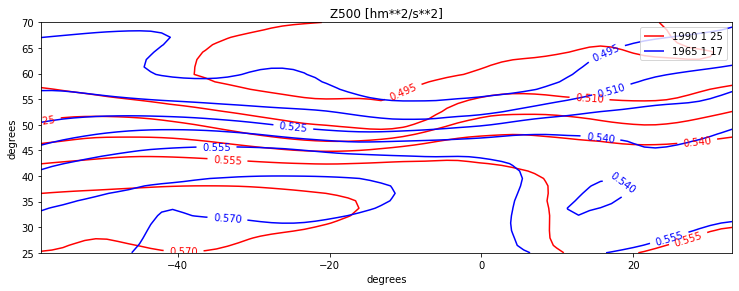

In [3]:
# for 2nd smallest: set nearby to 2
nearby = 1
min_dist_index = smallest_compressed[nearby]  
original = era20c[date_index].reshape(1,shape1,shape2,2)
nearest = era20c[min_dist_index].reshape(1,shape1,shape2,2)
isoplot(original[0,:,:,0],nearest[0,:,:,0],date,dates[min_dist_index],zone,scale[0])
isoplot(original[0,:,:,1],nearest[0,:,:,1],date,dates[min_dist_index],zone,scale[1],"Z500 [hm**2/s**2]")

## 4.4 Distance in compressed and uncompressed space
The scatter plots below show:
- distances in compressed versus uncompressed (scaled combined MSL/Z500) space
- compressed distances versus average MSL distances per gridpoint [Pa] 
- compressed distances versus average Z500 distances per gridpoint [m<sup>2</sup>/s<sup>2</sup>]

The correlation of the distances is the highest between uncompressed and Z500 space.

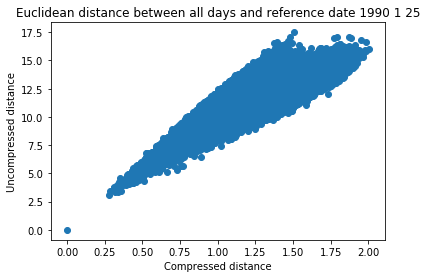

In [4]:
plt.scatter(compressed_dist, era20c_dist)
plt.ylabel("Uncompressed distance")
plt.xlabel("Compressed distance")
plt.title("Euclidean distance between all days and reference date " + date)
plt.show()

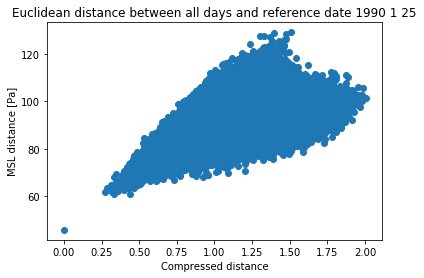

In [5]:
plt.scatter(compressed_dist, msl_dist)
plt.ylabel("MSL distance [Pa]")
plt.xlabel("Compressed distance")
plt.title("Euclidean distance between all days and reference date " + date)
plt.show()

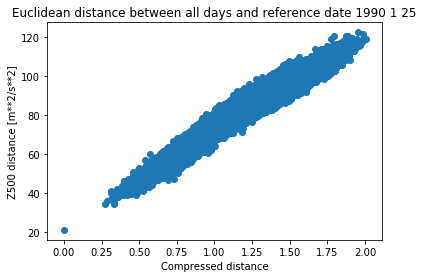

In [6]:
plt.scatter(compressed_dist, z500_dist)
plt.ylabel("Z500 distance [m**2/s**2]")
plt.xlabel("Compressed distance")
plt.title("Euclidean distance between all days and reference date " + date)
plt.show()